In [1]:
#load libraries
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle

In [2]:
#open twiss.out and read line by line, store each line as a string in a list
filename = "eL2L2.out"
copy_lines=[]
with open(filename) as f: #open and read the file
    lines = f.readlines()
for line in lines: 
    split_line = line.split() #split lines into words
    copy_lines.append(split_line)

#just declaring a list for each column
name,type,s,L,betx,alfx,Dx,bety,alfy,Dy,angle,K1L = [],[],[],[],[],[],[],[],[],[],[],[]

#from each line, extract a name/number and append it into its relevant column
for i in range(52,len(copy_lines)-1): #53rd line in the file is the first relevant one
    line = copy_lines[i]
    name.append(line[0])
    type.append(line[1])
    s.append(float(line[2]))
    L.append(float(line[3]))
    betx.append(float(line[4]))
    alfx.append(float(line[5]))
    Dx.append(float(line[6]))
    bety.append(float(line[7]))
    alfy.append(float(line[8]))
    Dy.append(float(line[9]))
    angle.append(float(line[10]))
    K1L.append(float(line[11]))

#create a dataframe that will contain all important info - name of place in an LHC sequence, beta functions, phases, fields, etc... of the UNPERTURBED version
d_transfer = {'name': name, 'type':type, 's': s, 'L':L, 'BETX': betx, 'ALFX':alfx, 'DX': Dx, 'BETY': bety, 'ALFY':alfy, 'DY': Dy, 'ANGLE':angle}
df_tr = pd.DataFrame(data=d_transfer) #df is the UNPERTURBED (model) version of twiss parameters
df_tr.head() #show header of the dataframe

,name,type,s,L,BETX,ALFX,DX,BETY,ALFY,DY,ANGLE
0,"""EL2L2$START""","""MARKER""",0.00,0.00,9.650000,0.000000,0.0,25.720000,0.000000,0.0,0.0
1,"""QEL2L2_FD_Q01""","""QUADRUPOLE""",0.10,0.10,9.477996,1.709688,0.0,26.187157,-4.699625,0.0,0.0
2,"""DEL2L2_FD_D01""","""DRIFT""",3.89,3.79,2.463999,0.140971,0.0,74.473637,-8.040871,0.0,0.0
3,"""QEL2L2_FD_Q02""","""QUADRUPOLE""",4.09,0.20,2.604511,-0.860400,0.0,72.309496,18.599224,0.0,0.0
4,"""DEL2L2_FD_D01""","""DRIFT""",7.88,3.79,18.724173,-3.392809,0.0,0.244377,0.415319,0.0,0.0


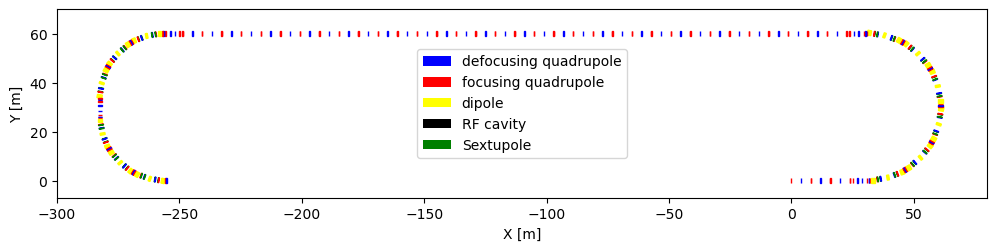

In [3]:
fig, ax = plt.subplots(figsize=(12, 8))
angle_tot=0 #cumulative total angle, needs to add up to 2pi after one turn
x_global,y_global=0,0 #global position in lab frame (not courant-snyder)
elem_width = 2 #width of an element for plotting in 2D
for type_,s_,L_,K1L_,angle_ in zip(type,s,L,K1L,angle): #for each element, plot a rectangular patch in lab frame
    x=x_global
    y=y_global
    if 'QUADRUPOLE' in type_:
        if K1L_<0: #if defocusing
            ax.add_patch(Rectangle((x, y-elem_width/2), L_, elem_width,angle=180*angle_tot/np.pi,color='blue'))
        else: #if focusing
            ax.add_patch(Rectangle((x, y-elem_width/2), L_, elem_width,angle=180*angle_tot/np.pi,color='red'))
    elif 'RFCAVITY' in type_:
        ax.add_patch(Rectangle((x, y-elem_width/2), L_, elem_width,angle=180*angle_tot/np.pi,color='black'))
    elif 'RBEND' in type_:
       ax.add_patch(Rectangle((x, y-elem_width/2), L_, elem_width,angle=180*angle_tot/np.pi,color='yellow'))
    elif 'SEXTUPOLE' in type_:
        ax.add_patch(Rectangle((x, y-elem_width/2), L_, elem_width,angle=180*angle_tot/np.pi,color='green'))
    x_global+=L_*np.cos((angle_tot+angle_))#update global position for the next element
    y_global+=L_*np.sin((angle_tot+angle_))
    angle_tot += angle_ #update cumulative angle (in radians)
plt.xlim(-300,80)
plt.ylim(-7,70)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
ax = plt.gca() #handle needed to fix aspect ratio of the plot (to preserve angles!)
ax.set_aspect(1) #fix aspect ratio

hndl = [Patch(facecolor='blue', label='defocusing quadrupole'),#make a legend corresponding to the color patches signifying lattice elements
        Patch(facecolor='red', label='focusing quadrupole'),
        Patch(facecolor='yellow', label='dipole'),
        Patch(facecolor='black', label='RF cavity'),
        Patch(facecolor='green', label='Sextupole')]
ax.legend(handles=hndl,loc='center')

Text(0, 0.5, 'D [m]')

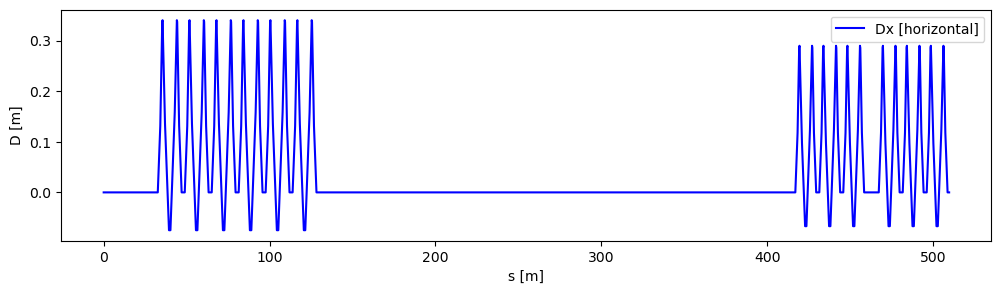

In [4]:
plt.figure(figsize=(12,3))
plt.plot(s,Dx, 'b',label='Dx [horizontal]')
#plt.plot(s,Dy, 'r',label='Dy [vertical]')
plt.legend(loc="upper right")
plt.xlabel('s [m]')
plt.ylabel('D [m]')

Text(0, 0.5, 'Alfa')

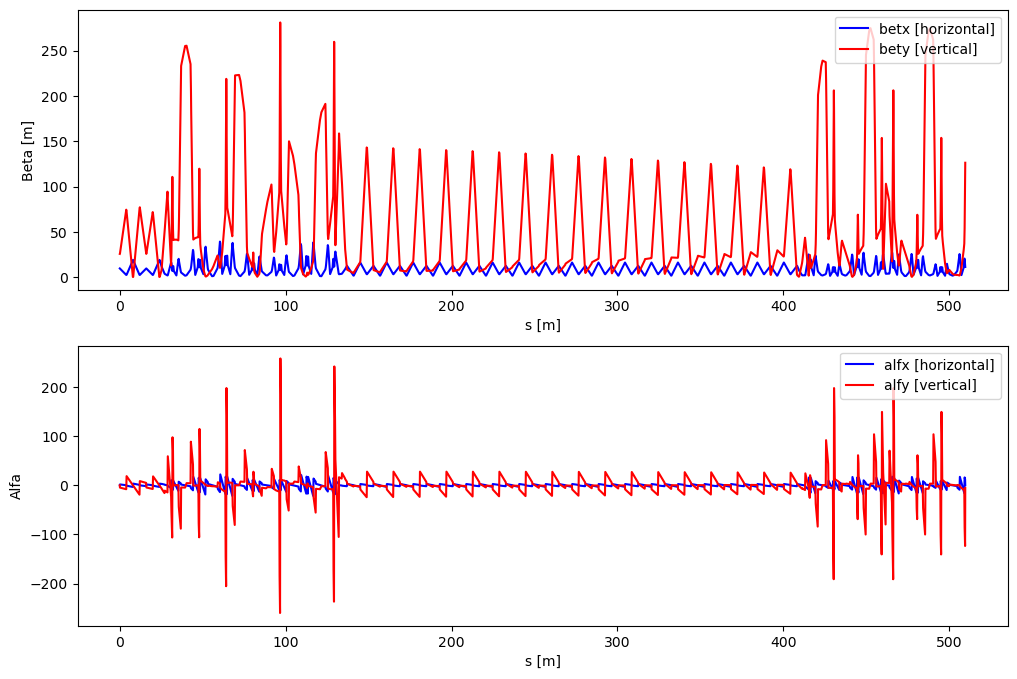

In [5]:
fig, (plt1, plt2) = plt.subplots(2, 1, figsize=(12, 8))
plt1.plot(s,betx, 'b',label='betx [horizontal]')
plt1.plot(s,bety, 'r',label='bety [vertical]')
plt1.legend(loc="upper right")
plt1.set_xlabel('s [m]')
plt1.set_ylabel('Beta [m]')

plt2.plot(s,alfx, 'b',label='alfx [horizontal]')
plt2.plot(s,alfy, 'r',label='alfy [vertical]')
plt2.legend(loc="upper right")
plt2.set_xlabel('s [m]')
plt2.set_ylabel('Alfa')